# Sentiment Analyse with Jupyter Notebook The Clinics Review Datas in Lower Saxsony Germany

Sentimentanalyse, auch _Opinion Mining_ genannt, ist das herausfinden der Meinung, die in einem Text zu igendetwas geäußert wird.

Es werden zwei Dimensionen, entlang denen Text klassifiziert werden können, unterschieden: 
 * Objektiv vs. Subjektiv und 
 * Negativ - Neutral - Positiv.

Längere Texte können natürlich mehrere Meinungen zu den gleichen und zu verschiedenen Sachen enthalten.

Unsere einfache Hypothese ist, dass es Wörter gibt, die eine stark positives oder negatives Sentiment verkörpern, und das es reicht diese Wörter zu finden, um einen Text zu klassifizieren. Diese Annahme ist natürlich nicht ganz korrekt. Eine positive ode negative Meinung hängt natürlich von mehr als nur von einzelnen Wörtern ab: insbesondere  Negation kann die Bedeutung eines Wortes grundlegend ändern. Einige ganz neue Verfahren (Stichwörter: ELMO und BERT) können auch mit der unterschiedliche Bedeutung von Wörtern in Abhängigkeit der umgebenden Wörter umgehen. Wir kommen aber schon ganz weit, wenn wir nur einzelne Wörter verwenden. Verfahren, die nur einzelne Wörter verwenden, ohne ihre Beziehungen zu berücksichtigen, nennt man übrigens _Bag of Word_-Verfahren.

Es gibt nun zwei Möglichkeiten die Idee umzusetzen:
1. Wir trainieren einen Classifier, der aus Beispieltexten lernt, wie viel jedes Wort zum positiven oder negativen Sentiment beiträgt. Der Vorteil dieser Methode ist, dass wie genaue gewichte für eine spezifische Domäne oder Textart lernen können. Wir nutzen die Bewertungdaten der Webseite klinikbewertung.de
2. Wir nutzen allgemeine Listen mit positiven und negativen Wörtern.

## Tools

Für die Sentimentanalyse brauchen wir in Grunde genommen nur Listen mit positiven und negativen Wörtern und eine Funktion, die zählt wie viele positive und negative Wörter es in einem Text gibt. Es gibt aber auch Tools, die das alles ganz unkomplziert für uns erledigen können. Für die Sentimentanalyse können wir die Bibiothek _TextBlob_ nutzen.

Das ist jetzt die dritte Bibliothek für NLP. Was sind die Unterschiede?

* NLTK: Eine Sammlung mit sehr vielen Algorithmen, meistens sprachunabhängig oder für viele Sprachen geeignet. Oft auch viele unterschiedliche Algorithmen für dieselbe Aufgabe. Ein Eldorado für Experte, die experimentieren und selber neue Anwendungen entwickeln wollen.
* TextBlob: eine Auswahl von Algorithmen aus NLTK, die zusammen eine Standard-Analyse eines Textes für einige wenige Sprachen ausführen können. Wenig Vorwissn erforderlich, einfach einzusetzen, aber ohne Möglichkeiten, etwas anzupassen.
* Spacy: von der Idee und Funktionalität sehr ähnlich zu TextBlob, etwas umfangreicher und vorallem mit eigener sehr performante Implementierung.

Weder NLTK noch Spacy enthalten eine fertig eingebaute Sentimentanalyse für Deutsche Texte. TextBlob bietet diese Funktionalität aber.  Deswegen in diesem Notebook werden wir Textblob nutezn um die Polarität zu zeigen.

## Textanalyse mit TextBlob
Using TextBlob to calculate sentiment polarity which lies in the range of [-1,1] where 1 means positive sentiment and -1 means a negative sentiment.
Zunächst installieren wir die Deutsche Version von TextBlob:

#### Danach importieren wir die Bibliotekhen, die benötigt werden.

In [134]:
import pandas as pd
import numpy as np
import nltk
import csv
import textblob
from textblob import TextBlob
from textblob_de import TextBlobDE
from textblob_de import PatternParser
import matplotlib.pyplot as plt
import matplotlib as mpl
from wordcloud import WordCloud, STOPWORDS
from textblob.sentiments import NaiveBayesAnalyzer
import numpy as npy
from PIL import Image
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
import bar_chart_race as bcr
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import re
import pickle
import sklearn

from bokeh.io import output_notebook
output_notebook()

from pathlib import Path


pd.options.display.max_columns = 100
pd.options.display.max_rows = 300
pd.options.display.max_colwidth = 100
np.set_printoptions(threshold=2000)

Loading BokehJS ...

In [135]:
#import holoviews as hv
#import hvplot
#from hvplot import pandas
#hv.extension("bokeh")
from xgboost import XGBClassifier


##### Konvertieren csv-Daten in Pandas DataFrame

In [361]:
data = pd.read_csv(r'C:\Users\name\Desktop\WB\Abschlussproject\ML\clinical_data_lowersaxony.csv', encoding='utf-8')

#### Wir erstellen Dataframe

In [388]:
df = pd.DataFrame(data, columns= ['K_ID','Name der Klinik', 'Titel','Datum','Fachbereich','Erfahrungsbericht','Gesamtzufriedenheit','Qualität der Beratung','Mediz. Behandlung','Verwaltung und Abläufe','Ausstattung und Gestaltung'])
df.head()

,K_ID,Name der Klinik,Titel,Datum,Fachbereich,Erfahrungsbericht,Gesamtzufriedenheit,Qualität der Beratung,Mediz. Behandlung,Verwaltung und Abläufe,Ausstattung und Gestaltung
0,1,Augenklinik Dr.Hoffmann,super Klinik,16.03.2021,Augen,Meine Laser OP grauer Star hat super geklappt. Alles lief wie am Schnürchen ab. Danke dafür.Dank...,sehr zufrieden,sehr zufrieden,sehr zufrieden,zufrieden,zufrieden
1,1,Augenklinik Dr.Hoffmann,Ich war sehr zufrieden mit allem,20.01.2021,Augen,Bin sehr zufrieden gewesen mit der Klinik und dem Personal. Die erste OP verlief sehr gut +die ...,sehr zufrieden,sehr zufrieden,sehr zufrieden,sehr zufrieden,sehr zufrieden
2,1,Augenklinik Dr.Hoffmann,Endlich wieder klare Sicht,16.11.2020,Augen,Komptentes Ärzteteam.Strickte Einhaltung der Corona Schutzregeln.Rundum zufrieden,sehr zufrieden,sehr zufrieden,sehr zufrieden,sehr zufrieden,sehr zufrieden
3,1,Augenklinik Dr.Hoffmann,Beste Augenklinik,22.03.2020,Augen,Ich komme seit einen halben Jahr mit meiner behinderten Frau hier zum Augen-Spritzen auf Grund e...,sehr zufrieden,sehr zufrieden,sehr zufrieden,sehr zufrieden,sehr zufrieden
4,1,Augenklinik Dr.Hoffmann,ich war ringsherum zufrieden,14.11.2019,Augen,Ich war Anfang November 2019 zur Augen-OP (Grauer Star)in der Klinik und zunächst wegen negative...,sehr zufrieden,sehr zufrieden,sehr zufrieden,zufrieden,sehr zufrieden


In [363]:
df.dtypes

K_ID                           int64
Name der Klinik               object
Titel                         object
Datum                         object
Fachbereich                   object
Erfahrungsbericht             object
Gesamtzufriedenheit           object
Qualität der Beratung         object
Mediz. Behandlung             object
Verwaltung und Abläufe        object
Ausstattung und Gestaltung    object
dtype: object

In [364]:
#df.info

## Preproccessing and Data Preparation

Obwohl wir die Daten als UTF-8 kodiert haben, sollen wir einige Falsche Wörter ändern.

In [389]:
def preprocess(ReviewText):
    ReviewText= ReviewText.str.replace('\n','')
    ReviewText= ReviewText.str.replace('Ã¶','ö')
    ReviewText= ReviewText.str.replace('Ã\x84','Ä')
    ReviewText= ReviewText.str.replace('Ã¤','ä')
    ReviewText= ReviewText.str.replace('Ã¼','ü')
    ReviewText= ReviewText.str.replace('Ã\x9f','ß')
    ReviewText= ReviewText.str.replace('Ã\x9c','Ü')
    return ReviewText
df.Erfahrungsbericht = preprocess(df.Erfahrungsbericht)
df['Titel'] = preprocess(df['Titel'])

In [390]:
df['Gesamtzufriedenheit']=df['Gesamtzufriedenheit'].str.replace(r"\(.*\)","")
df['Qualität der Beratung']=df['Qualität der Beratung'].str.replace(r"\(.*\)","")
df['Mediz. Behandlung']=df['Mediz. Behandlung'].str.replace(r"\(.*\)","")
df['Verwaltung und Abläufe']=df['Verwaltung und Abläufe'].str.replace(r"\(.*\)","")
df['Ausstattung und Gestaltung']=df['Ausstattung und Gestaltung'].str.replace(r"\(.*\)","")


In [391]:
df.head()

,K_ID,Name der Klinik,Titel,Datum,Fachbereich,Erfahrungsbericht,Gesamtzufriedenheit,Qualität der Beratung,Mediz. Behandlung,Verwaltung und Abläufe,Ausstattung und Gestaltung
0,1,Augenklinik Dr.Hoffmann,super Klinik,16.03.2021,Augen,Meine Laser OP grauer Star hat super geklappt. Alles lief wie am Schnürchen ab. Danke dafür.Dank...,sehr zufrieden,sehr zufrieden,sehr zufrieden,zufrieden,zufrieden
1,1,Augenklinik Dr.Hoffmann,Ich war sehr zufrieden mit allem,20.01.2021,Augen,Bin sehr zufrieden gewesen mit der Klinik und dem Personal. Die erste OP verlief sehr gut +die ...,sehr zufrieden,sehr zufrieden,sehr zufrieden,sehr zufrieden,sehr zufrieden
2,1,Augenklinik Dr.Hoffmann,Endlich wieder klare Sicht,16.11.2020,Augen,Komptentes Ärzteteam.Strickte Einhaltung der Corona Schutzregeln.Rundum zufrieden,sehr zufrieden,sehr zufrieden,sehr zufrieden,sehr zufrieden,sehr zufrieden
3,1,Augenklinik Dr.Hoffmann,Beste Augenklinik,22.03.2020,Augen,Ich komme seit einen halben Jahr mit meiner behinderten Frau hier zum Augen-Spritzen auf Grund e...,sehr zufrieden,sehr zufrieden,sehr zufrieden,sehr zufrieden,sehr zufrieden
4,1,Augenklinik Dr.Hoffmann,ich war ringsherum zufrieden,14.11.2019,Augen,Ich war Anfang November 2019 zur Augen-OP (Grauer Star)in der Klinik und zunächst wegen negative...,sehr zufrieden,sehr zufrieden,sehr zufrieden,zufrieden,sehr zufrieden


In [392]:
df["Gesamtzufriedenheit"].unique()

array(['sehr zufrieden', 'weniger zufrieden', 'zufrieden', 'unzufrieden'],
      dtype=object)

In [393]:
bewertunglist=['Gesamtzufriedenheit','Qualität der Beratung','Mediz. Behandlung','Verwaltung und Abläufe','Ausstattung und Gestaltung']
sternelist=['Gesamt','Qualität','Behandlung','Verwaltung','Ausstattung']

In [394]:
for w in range(len(bewertunglist)):
    df[bewertunglist[w]]=df[bewertunglist[w]].str.replace(r"sehr zufrieden ","sehr zufrieden")
    df[bewertunglist[w]]=df[bewertunglist[w]].str.replace(r"weniger zufrieden ","weniger zufrieden")
    df[bewertunglist[w]]=df[bewertunglist[w]].str.replace(r"zufrieden ","zufrieden")
    df[bewertunglist[w]]=df[bewertunglist[w]].str.replace(r"unzufrieden ","zufrieden")

In [395]:
df["Qualität der Beratung"].unique()

array(['sehr zufrieden', 'unzufrieden', 'zufrieden', 'weniger zufrieden'],
      dtype=object)

In [396]:
for b in range(len(bewertunglist)):    
    df.loc[df[bewertunglist[b]] =="sehr zufrieden", sternelist[b]] = 6
    df.loc[df[bewertunglist[b]] =="zufrieden", sternelist[b]] = 4
    df.loc[df[bewertunglist[b]] =="weniger zufrieden", sternelist[b]] = 2
    df.loc[df[bewertunglist[b]] =="unzufrieden", sternelist[b]] = 0

In [397]:
df.head()

,K_ID,Name der Klinik,Titel,Datum,Fachbereich,Erfahrungsbericht,Gesamtzufriedenheit,Qualität der Beratung,Mediz. Behandlung,Verwaltung und Abläufe,Ausstattung und Gestaltung,Gesamt,Qualität,Behandlung,Verwaltung,Ausstattung
0,1,Augenklinik Dr.Hoffmann,super Klinik,16.03.2021,Augen,Meine Laser OP grauer Star hat super geklappt. Alles lief wie am Schnürchen ab. Danke dafür.Dank...,sehr zufrieden,sehr zufrieden,sehr zufrieden,zufrieden,zufrieden,6.0,6.0,6.0,4.0,4.0
1,1,Augenklinik Dr.Hoffmann,Ich war sehr zufrieden mit allem,20.01.2021,Augen,Bin sehr zufrieden gewesen mit der Klinik und dem Personal. Die erste OP verlief sehr gut +die ...,sehr zufrieden,sehr zufrieden,sehr zufrieden,sehr zufrieden,sehr zufrieden,6.0,6.0,6.0,6.0,6.0
2,1,Augenklinik Dr.Hoffmann,Endlich wieder klare Sicht,16.11.2020,Augen,Komptentes Ärzteteam.Strickte Einhaltung der Corona Schutzregeln.Rundum zufrieden,sehr zufrieden,sehr zufrieden,sehr zufrieden,sehr zufrieden,sehr zufrieden,6.0,6.0,6.0,6.0,6.0
3,1,Augenklinik Dr.Hoffmann,Beste Augenklinik,22.03.2020,Augen,Ich komme seit einen halben Jahr mit meiner behinderten Frau hier zum Augen-Spritzen auf Grund e...,sehr zufrieden,sehr zufrieden,sehr zufrieden,sehr zufrieden,sehr zufrieden,6.0,6.0,6.0,6.0,6.0
4,1,Augenklinik Dr.Hoffmann,ich war ringsherum zufrieden,14.11.2019,Augen,Ich war Anfang November 2019 zur Augen-OP (Grauer Star)in der Klinik und zunächst wegen negative...,sehr zufrieden,sehr zufrieden,sehr zufrieden,zufrieden,sehr zufrieden,6.0,6.0,6.0,4.0,6.0


Mithilfe dieser Code bekommen wir alle textuelle Bewertungen für ein Krankenhaus

In [398]:
kliniklist=df["Name der Klinik"].unique()
kliniklist[0]
kliniklist
#df["Name der Klinik"][0]

array(['Augenklinik Dr.Hoffmann', 'Krankenhaus Marienstift Braunschweig',
       'Herzogin Elisabeth Hospital Braunschweig',
       'Asklepios Fachklinikum Göttingen',
       'Asklepios Fachklinikum Tiefenbrunn', 'Friederikenstift Hannover',
       'Annastift Hannover', 'Clementinenhaus', 'Sophienklinik Hannover',
       'KRH Klinikum Großburgwedel', 'KRH Klinikum Lehrte',
       'Krankenhaus Lindenbrunn', 'Krankenhaus Hameln',
       'AMEOS Klinikum Alfeld', 'Helios Klinikum Hildesheim',
       'Helios Klinikum Cuxhaven', 'OsteMed Klinik Bremervörde',
       'Klinik Fallingborstel', 'Klinikum Emden',
       'Krankenhaus Ludmillenstift', 'Marienhospital Papenburg',
       'Kreiskrankenhaus Osterholz'], dtype=object)

In [399]:
df.shape

(2847, 16)

In [435]:
def sentimentklinik(klinikname):
    erfahrungsberichten=[]
    for i in range(df.shape[0]):
        if df.iloc[i,1] == klinikname:
            erfahrungsberichten.append(df.iloc[i,5])
    return erfahrungsberichten          

In [437]:
#sentimentklinik("Kreiskrankenhaus Osterholz")

In [438]:
reviewlist=[]

In [439]:
for j in range(len(df["Name der Klinik"].unique())):
    review=sentimentklinik(kliniklist[j])
    reviewlist.append(review)

In [555]:
#reviewlist[0]

To test the classification performance of our model, we will perform a cross validation. For that, we split our data into a training and a testing set. The former is used to train the model and the latter to evaluate its predictions:

Dieser Review laden wir jetzt in ein TextBlob-Objekt. Dabei wird dieser Review vollständig analysiert. Anschließend können wir die Analysen aus dem Objekt auslesen.

In [442]:
blob = TextBlobDE(str(reviewlist[0]))

In [443]:
blob.sentiment

Sentiment(polarity=0.1244017094017094, subjectivity=0.0576923076923077)

In [444]:
blob.sentences[10:12]

[Sentence("Von den Ärzten bekommt man alles genau erklärt - hier fühlt man sich in guten Händen - Danke an das gesamte Ärzte und Schwesternteam."),
 Sentence("', 'Ich war Anfang November 2019 zur Augen-OP (Grauer Star)in der Klinik und zunächst wegen negativer Meinungen voller Bedenken.")]

In [445]:
blob.tokens[20:30]

WordList(['an', 'den', 'neuen', 'Küchenchef', 'für', 'das', 'tolle', 'Brötchen', '.', '('])

In [447]:
#blob.tags[4800:4850]

In [416]:
#blob.word_counts

In [448]:
review1 = str(review).split(' ')
freq = nltk.FreqDist(review1)

In [450]:
#freq.most_common(15)

In [451]:
#blob.words.lemmatize()[300:350]

## Google Maps Data

In [505]:
datagoogle = pd.read_csv(r'C:\Users\name\Desktop\WB\Abschlussproject\klinikbewertung.de\clinical_data_lowersaxony_google.csv', encoding='utf-8')

In [507]:
dfgoogle = pd.DataFrame(datagoogle, columns= ['Name der Klinik','Textuelle Bewertung','Sternebewertung', 'Datum der Bewertung','Likes'])
len(dfgoogle)

3253

In [516]:
dfgoogle.dropna(subset = ["Textuelle Bewertung"], inplace=True)
dfgoogle.dropna(subset = ["Sternebewertung"], inplace=True)
len(dfgoogle)
dfgoogle.tail()

,Name der Klinik,Textuelle Bewertung,Sternebewertung,Datum der Bewertung,Likes
3231,Kreiskrankenhaus Osterholz,"Ambulante Versorgung bei meinem Ehemann, waren freundlich zugewandt und keine langen Wartezeiten...",3,vor 3 Jahren,No Like
3232,Kreiskrankenhaus Osterholz,Sehr gute Ärzte war am 20.04.2018 zur ambulanten OP im Krankenhaus Osterholz Scharmbeck von der ...,5,vor 2 Jahren,No Like
3233,Kreiskrankenhaus Osterholz,Schönes kleines Krankenhaus mit sehr nettem Personal,5,vor einem Jahr,No Like
3234,Kreiskrankenhaus Osterholz,Gute Pflege in einem guten Krankenhaus,5,vor 2 Jahren,No Like
3235,Kreiskrankenhaus Osterholz,"Gynäkologie Arzt sehr unfreundlich ,schlechte Beratung",1,vor 3 Jahren,No Like


In [519]:
reviewlistgoogle=[]

In [522]:
dfgoogle.iloc[200,1]

'Mir wurden vor kurzem Drähte und Schrauben in meinen Fuß operiert, welche nun jedoch extreme Probleme verursachen mit Höllenschmerzen und möglicherweise auch Langzeitschäden wenn sie nicht schnellstmöglich wieder heraus genommen werden. In diesem Krankenhaus habe ich versucht das Problem zu schildern, jedoch darf man nicht mal aussprechen sondern wird direkt unterbrochen. Dann bekommt man einen Gesprächstermin für in 3 Monaten!! Da das noch nicht genug ist, kann man mir dann aber noch keinen op Termin nennen - was mindestens noch mal eine Wartezeit von einem Monat bedeutet. Auch hier wird man frech unterbrochen. Wenn das schon so anfängt, kann man vermutlich nur froh sein, dass man hier nicht operiert wird. Meiner Ansicht nach absolut nicht zu empfehlen wenn man so mit Patienten umgeht.'

In [523]:
def sentimentgoogle(klinikname):
    erfahrung=[]
    for i in range(dfgoogle.shape[0]):
        if dfgoogle.iloc[i,0] == klinikname:
            erfahrung.append(dfgoogle.iloc[i,1])
    return erfahrung

In [524]:
len(dfgoogle["Name der Klinik"].unique())

22

In [525]:
for j in range(len(dfgoogle["Name der Klinik"].unique())):
    review1=sentimentgoogle(kliniklist[j])
    reviewlistgoogle.append(review1)

In [533]:
kliniklistgoogle=df["Name der Klinik"].unique()
kliniklistgoogle

array(['Augenklinik Dr.Hoffmann', 'Krankenhaus Marienstift Braunschweig',
       'Herzogin Elisabeth Hospital Braunschweig',
       'Asklepios Fachklinikum Göttingen',
       'Asklepios Fachklinikum Tiefenbrunn', 'Friederikenstift Hannover',
       'Annastift Hannover', 'Clementinenhaus', 'Sophienklinik Hannover',
       'KRH Klinikum Großburgwedel', 'KRH Klinikum Lehrte',
       'Krankenhaus Lindenbrunn', 'Krankenhaus Hameln',
       'AMEOS Klinikum Alfeld', 'Helios Klinikum Hildesheim',
       'Helios Klinikum Cuxhaven', 'OsteMed Klinik Bremervörde',
       'Klinik Fallingborstel', 'Klinikum Emden',
       'Krankenhaus Ludmillenstift', 'Marienhospital Papenburg',
       'Kreiskrankenhaus Osterholz'], dtype=object)

In [527]:
#reviewlistgoogle

In [455]:
#del dfgoogle["Datum der Bewertung"]

In [456]:
#del dfgoogle["Likes"]
#dfgoogle.tail()

In [457]:
dfklinik=df.copy()
dfklinik.head()

,K_ID,Name der Klinik,Titel,Datum,Fachbereich,Erfahrungsbericht,Gesamtzufriedenheit,Qualität der Beratung,Mediz. Behandlung,Verwaltung und Abläufe,Ausstattung und Gestaltung,Gesamt,Qualität,Behandlung,Verwaltung,Ausstattung
0,1,Augenklinik Dr.Hoffmann,super Klinik,16.03.2021,Augen,Meine Laser OP grauer Star hat super geklappt. Alles lief wie am Schnürchen ab. Danke dafür.Dank...,sehr zufrieden,sehr zufrieden,sehr zufrieden,zufrieden,zufrieden,6.0,6.0,6.0,4.0,4.0
1,1,Augenklinik Dr.Hoffmann,Ich war sehr zufrieden mit allem,20.01.2021,Augen,Bin sehr zufrieden gewesen mit der Klinik und dem Personal. Die erste OP verlief sehr gut +die ...,sehr zufrieden,sehr zufrieden,sehr zufrieden,sehr zufrieden,sehr zufrieden,6.0,6.0,6.0,6.0,6.0
2,1,Augenklinik Dr.Hoffmann,Endlich wieder klare Sicht,16.11.2020,Augen,Komptentes Ärzteteam.Strickte Einhaltung der Corona Schutzregeln.Rundum zufrieden,sehr zufrieden,sehr zufrieden,sehr zufrieden,sehr zufrieden,sehr zufrieden,6.0,6.0,6.0,6.0,6.0
3,1,Augenklinik Dr.Hoffmann,Beste Augenklinik,22.03.2020,Augen,Ich komme seit einen halben Jahr mit meiner behinderten Frau hier zum Augen-Spritzen auf Grund e...,sehr zufrieden,sehr zufrieden,sehr zufrieden,sehr zufrieden,sehr zufrieden,6.0,6.0,6.0,6.0,6.0
4,1,Augenklinik Dr.Hoffmann,ich war ringsherum zufrieden,14.11.2019,Augen,Ich war Anfang November 2019 zur Augen-OP (Grauer Star)in der Klinik und zunächst wegen negative...,sehr zufrieden,sehr zufrieden,sehr zufrieden,zufrieden,sehr zufrieden,6.0,6.0,6.0,4.0,6.0


##### We delete all data we don't need.

In [458]:
del dfklinik["Gesamtzufriedenheit"]
del dfklinik["Qualität der Beratung"]
del dfklinik["Mediz. Behandlung"]
del dfklinik["Verwaltung und Abläufe"]
del dfklinik["Ausstattung und Gestaltung"]
del dfklinik["Qualität"]
del dfklinik["Behandlung"]
del dfklinik["Verwaltung"]
del dfklinik["Ausstattung"]
del dfklinik["K_ID"]
del dfklinik["Titel"]
del dfklinik["Datum"]
del dfklinik["Fachbereich"]

In [459]:
dfklinik.rename(columns={'Erfahrungsbericht': 'Textuelle Bewertung', 'Gesamt': 'Sternebewertung'}, inplace=True)
dfklinik.head()

,Name der Klinik,Textuelle Bewertung,Sternebewertung
0,Augenklinik Dr.Hoffmann,Meine Laser OP grauer Star hat super geklappt. Alles lief wie am Schnürchen ab. Danke dafür.Dank...,6.0
1,Augenklinik Dr.Hoffmann,Bin sehr zufrieden gewesen mit der Klinik und dem Personal. Die erste OP verlief sehr gut +die ...,6.0
2,Augenklinik Dr.Hoffmann,Komptentes Ärzteteam.Strickte Einhaltung der Corona Schutzregeln.Rundum zufrieden,6.0
3,Augenklinik Dr.Hoffmann,Ich komme seit einen halben Jahr mit meiner behinderten Frau hier zum Augen-Spritzen auf Grund e...,6.0
4,Augenklinik Dr.Hoffmann,Ich war Anfang November 2019 zur Augen-OP (Grauer Star)in der Klinik und zunächst wegen negative...,6.0


##### we combine two different dataframe, df and dfgoogle

In [463]:
result = pd.concat([dfklinik, dfgoogle], ignore_index=True, sort=False)
result.head()

,Name der Klinik,Textuelle Bewertung,Sternebewertung,Datum der Bewertung,Likes
0,Augenklinik Dr.Hoffmann,Meine Laser OP grauer Star hat super geklappt. Alles lief wie am Schnürchen ab. Danke dafür.Dank...,6.0,NaN,NaN
1,Augenklinik Dr.Hoffmann,Bin sehr zufrieden gewesen mit der Klinik und dem Personal. Die erste OP verlief sehr gut +die ...,6.0,NaN,NaN
2,Augenklinik Dr.Hoffmann,Komptentes Ärzteteam.Strickte Einhaltung der Corona Schutzregeln.Rundum zufrieden,6.0,NaN,NaN
3,Augenklinik Dr.Hoffmann,Ich komme seit einen halben Jahr mit meiner behinderten Frau hier zum Augen-Spritzen auf Grund e...,6.0,NaN,NaN
4,Augenklinik Dr.Hoffmann,Ich war Anfang November 2019 zur Augen-OP (Grauer Star)in der Klinik und zunächst wegen negative...,6.0,NaN,NaN


In [464]:
del result["Datum der Bewertung"]
del result["Likes"]

In [465]:
result.head()

,Name der Klinik,Textuelle Bewertung,Sternebewertung
0,Augenklinik Dr.Hoffmann,Meine Laser OP grauer Star hat super geklappt. Alles lief wie am Schnürchen ab. Danke dafür.Dank...,6.0
1,Augenklinik Dr.Hoffmann,Bin sehr zufrieden gewesen mit der Klinik und dem Personal. Die erste OP verlief sehr gut +die ...,6.0
2,Augenklinik Dr.Hoffmann,Komptentes Ärzteteam.Strickte Einhaltung der Corona Schutzregeln.Rundum zufrieden,6.0
3,Augenklinik Dr.Hoffmann,Ich komme seit einen halben Jahr mit meiner behinderten Frau hier zum Augen-Spritzen auf Grund e...,6.0
4,Augenklinik Dr.Hoffmann,Ich war Anfang November 2019 zur Augen-OP (Grauer Star)in der Klinik und zunächst wegen negative...,6.0


## Sentiment Analyse der Krankenhäusern
### 1- Polarität
### 2. Subjektivität
Wir bekommen die Ergebnisse, Polarität und Subjektivität der Bewertungen

In [534]:
dfsentiment = pd.DataFrame(columns= ['Name der Klinik', 'Polarität Klinik','Subjektivität Klinik', 'Polarität Google Maps','Subjektivität Google Maps']) #"P_Positive","P_Negative", "Classification"
dfsentiment

,Name der Klinik,Polarität Klinik,Subjektivität Klinik,Polarität Google Maps,Subjektivität Google Maps


In [535]:
for t in range(len(df["Name der Klinik"].unique())):
    blob=TextBlobDE(str(reviewlist[t]))
    polarity=blob.sentiment[0]
    subjectivity=blob.sentiment[1]
    
    blobs=TextBlobDE(str(reviewlistgoogle[t]))
    polaritys=blobs.sentiment[0]
    subjectivitys=blobs.sentiment[1]
    
    dfsentiment= dfsentiment.append({'Name der Klinik':kliniklist[t],'Polarität Klinik':polarity,'Subjektivität Klinik':subjectivity, 'Polarität Google Maps':polaritys,'Subjektivität Google Maps':subjectivitys}, ignore_index=True)
dfsentiment

,Name der Klinik,Polarität Klinik,Subjektivität Klinik,Polarität Google Maps,Subjektivität Google Maps
0,Augenklinik Dr.Hoffmann,0.124402,0.057692,0.315761,0.049978
1,Krankenhaus Marienstift Braunschweig,0.278212,0.059754,0.269459,0.068900
2,Herzogin Elisabeth Hospital Braunschweig,0.282841,0.043591,0.169497,0.061643
3,Asklepios Fachklinikum Göttingen,0.078114,0.065302,0.384797,0.048549
4,Asklepios Fachklinikum Tiefenbrunn,0.167924,0.098143,0.262083,0.065814
5,Friederikenstift Hannover,0.139751,0.056681,0.205656,0.060712
6,Annastift Hannover,0.255384,0.046842,0.298558,0.084276
7,Clementinenhaus,0.261116,0.045622,0.385896,0.035408
8,Sophienklinik Hannover,0.176457,0.049655,0.272479,0.035768
9,KRH Klinikum Großburgwedel,0.163068,0.052546,0.158194,0.031045


In [470]:
#dfsentiment

In [485]:
dfsentiment.sort_values(by=["Polarität Klinik"], ascending=False,inplace=True)

In [578]:
group_data = dfsentiment["Polarität Klinik"]
group_names = dfsentiment["Name der Klinik"]
group_mean = np.mean(group_data)

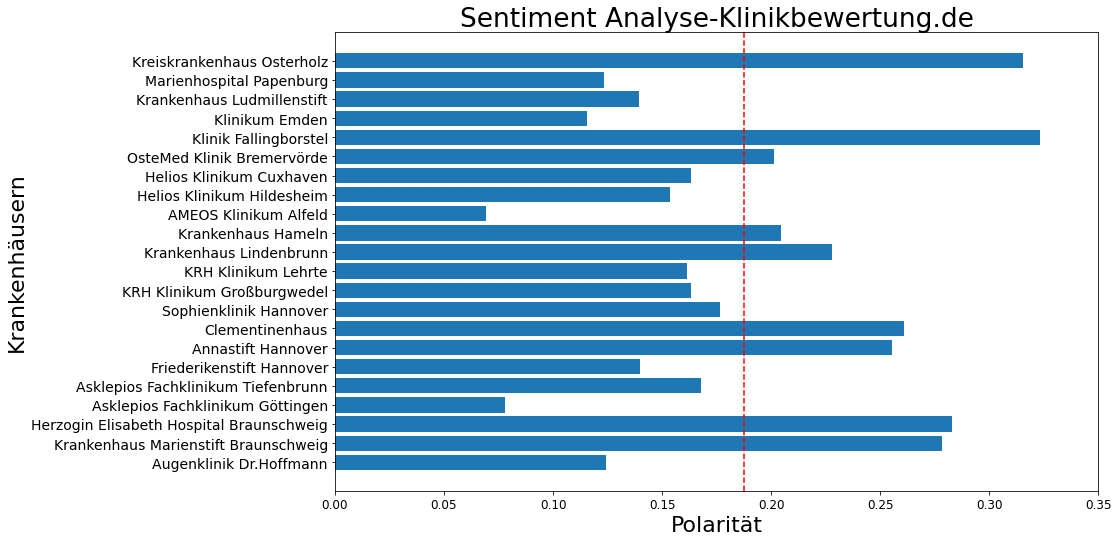

In [579]:
plt.rcParams.update({'figure.autolayout': True, 'font.size': 22})
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=14)
fig, ax = plt.subplots(figsize=(16, 8))
ax.barh(group_names, group_data)
ax.set(xlim=[0, 0.35], xlabel='Polarität', ylabel='Krankenhäusern',title='Sentiment Analyse-Klinikbewertung.de')
ax.axvline(group_mean, ls='--', color='r')
plt.savefig("img/A_k_senti_Graph.png", dpi=300)
#df_sorted_desc= dfsentiment.sort_values('Polarität',ascending=False)

In [86]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

In [591]:
group_datas = dfsentiment["Polarität Google Maps"]
group_names = dfsentiment["Name der Klinik"]
group_means = np.mean(group_data)

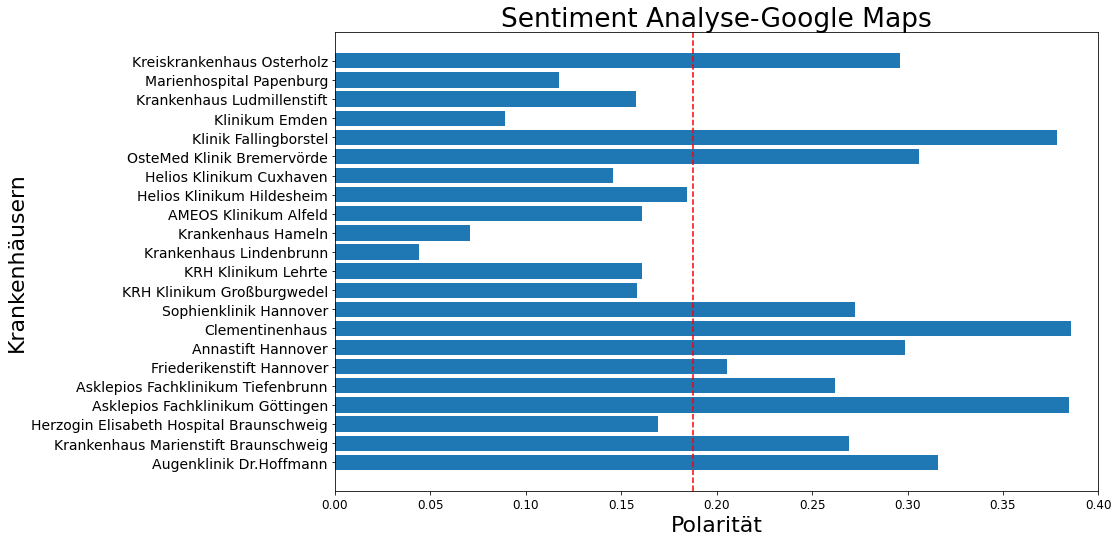

In [592]:
plt.rcParams.update({'figure.autolayout': True, 'font.size': 22})
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=14)
fig, ax = plt.subplots(figsize=(16, 8))
ax.barh(group_names, group_datas)
ax.set(xlim=[0, 0.4], xlabel='Polarität', ylabel='Krankenhäusern',title='Sentiment Analyse-Google Maps')
ax.axvline(group_mean, ls='--', color='r', label="Mean")
#plt.savefig("img/A_g_senti_Graph.png", dpi=300)
#df_sorted_desc= dfsentiment.sort_values('Polarität',ascending=False)

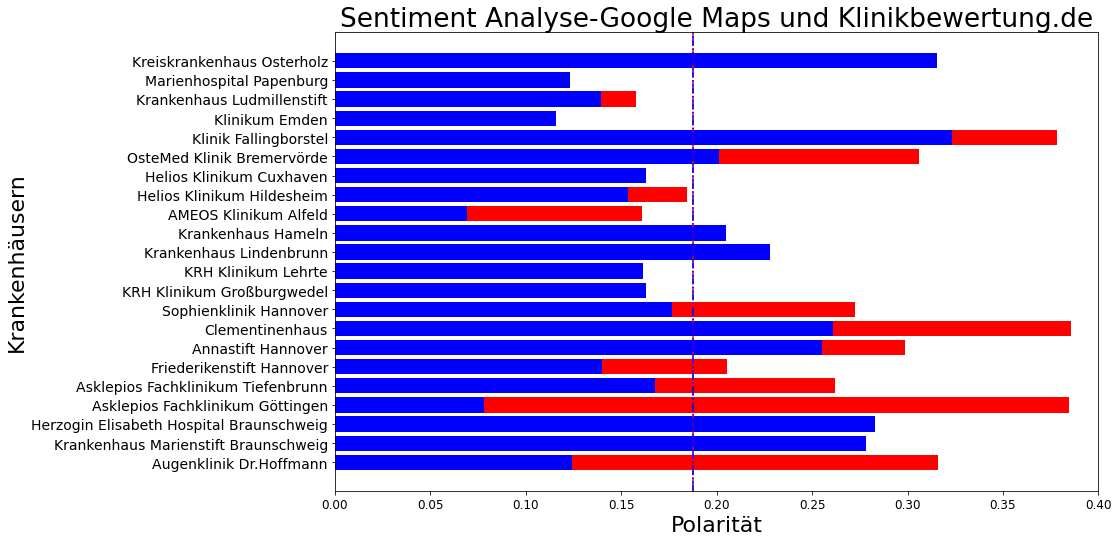

In [596]:
plt.rcParams.update({'figure.autolayout': True, 'font.size': 22})
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=14)
fig, ax = plt.subplots(figsize=(16, 8))
ax = plt.subplot(111)
ax.barh(group_names, group_datas, color="r")
ax.barh(group_names, group_data, color="b")
ax.set(xlim=[0, 0.4], xlabel='Polarität', ylabel='Krankenhäusern',title='Sentiment Analyse-Google Maps und Klinikbewertung.de')
ax.axvline(group_mean, ls='--', color='r', label="Mean")
ax.axvline(group_means, ls='-.', color='b', label="Mean")
plt.savefig("img/A_kg_senti_Graph.png", dpi=300)
#df_sorted_desc= dfsentiment.sort_values('Polarität',ascending=False)
#ax = plt.subplot(111)
#ax.bar(x-0.2, y, width=0.2, color='b', align='center')
#ax.bar(x, z, width=0.2, color='g', align='center')
#ax.bar(x+0.2, k, width=0.2, color='r', align='center')

In [541]:
kliniklistgoogle=dfgoogle["Name der Klinik"].unique()
kliniklistgoogle

array(['Augenklinik Dr.Hoffmann', 'Krankenhaus Marienstift Braunschweig',
       'Herzogin Elisabeth Hospital Braunschweig',
       'Asklepios Fachklinikum Göttingen',
       'Asklepios Fachklinikum Tiefenbrunn', 'Friederikenstift Hannover',
       'Annastift Hannover', 'Clementinenhaus', 'Sophienklinik Hannover',
       'KRH Klinikum Großburgwedel', 'KRH Klinikum Lehrte',
       'Krankenhaus Lindenbrunn', 'Krankenhaus Hameln',
       'AMEOS Klinikum Alfeld', 'Helios Klinikum Hildesheim',
       'Helios Klinikum Cuxhaven', 'OsteMed Klinik Bremervörde',
       'Klinik Fallingborstel', 'Klinikum Emden',
       'Krankenhaus Ludmillenstift', 'Marienhospital Papenburg',
       'Kreiskrankenhaus Osterholz'], dtype=object)

## WordCloud

In [550]:
#%matplotlib inline
german_stop_words = stopwords.words('german')

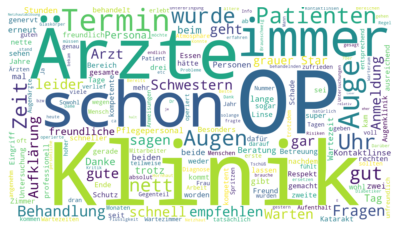

In [559]:
wordcloud = WordCloud(stopwords=german_stop_words, background_color="white",width=1920, height=1080, max_words=200).generate(str(reviewlist[0])) #width=1920, , height=1080 reviewlist[0]
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
#plt.savefig("img/drhoffman1.png") #, dpi=300
plt.rcParams['figure.figsize'] = [12, 8]
plt.show()

Mittels folgenden Code können wir alle WordCloud für jedes Krankenhaus bekommen and auf unserem Rechner speichern.

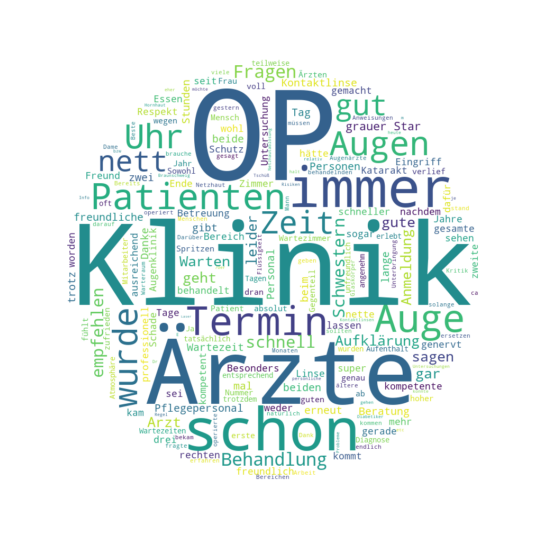

In [560]:
x, y = np.ogrid[:1000, :1000]
mask = (x - 500) ** 2 + (y - 500) ** 2 > 400 ** 2
mask = 255 * mask.astype(int)
german_stop_words = stopwords.words('german')
wordcloud = WordCloud(stopwords=german_stop_words,background_color="white",width=1920, height=1080, mask=mask).generate(str(reviewlist[0]))
plt.imshow(wordcloud, extent=(8, 70, 8, 70), interpolation="bilinear")
plt.axis("off")
#plt.savefig('plot.png', dpi=300)
#plt.savefig("drhoffmann.png", format="png")
plt.show()

In [561]:
df["Name der Klinik"].unique()

array(['Augenklinik Dr.Hoffmann', 'Krankenhaus Marienstift Braunschweig',
       'Herzogin Elisabeth Hospital Braunschweig',
       'Asklepios Fachklinikum Göttingen',
       'Asklepios Fachklinikum Tiefenbrunn', 'Friederikenstift Hannover',
       'Annastift Hannover', 'Clementinenhaus', 'Sophienklinik Hannover',
       'KRH Klinikum Großburgwedel', 'KRH Klinikum Lehrte',
       'Krankenhaus Lindenbrunn', 'Krankenhaus Hameln',
       'AMEOS Klinikum Alfeld', 'Helios Klinikum Hildesheim',
       'Helios Klinikum Cuxhaven', 'OsteMed Klinik Bremervörde',
       'Klinik Fallingborstel', 'Klinikum Emden',
       'Krankenhaus Ludmillenstift', 'Marienhospital Papenburg',
       'Kreiskrankenhaus Osterholz'], dtype=object)

In [567]:
#dfgoogle["Name der Klinik"].unique()

In [562]:
listeneu=['Augenklinik - Dr. Hoffmann','Krankenhaus der evangelisch-lutherischen Diakonissenanstalt Marienstift',
          'HEH Herzogin Elisabeth Hospital','Asklepios Fachklinikum Göttingen',
          'Asklepios Fachklinikum Tiefenbrunn','DIAKOVERE Friederikenstift',
          'DIAKOVERE Annastift', 'DRK-Clementinenhaus', 'Sophienklinik GmbH',
          'KRH Klinikum Großburgwedel', 'KRH Klinikum Lehrte',
          'Krankenhaus Lindenbrunn', 'Sana Klinikum Hameln-Pyrmont',
          'Kreis- und Stadtkrankenhaus Alfeld','HELIOS Klinikum Hildesheim GmbH',
          'HELIOS Klinik Cuxhaven', 'Ostemed Klinik Bremervörde',
          'Klinik Fallingbostel','Klinikum Emden', 
          'Krankenhaus Ludmillenstift',  'Marien Hospital Papenburg-Aschendorf',
          'Kreiskrankenhaus Osterholz',
       ]


In [563]:
len(listeneu)
listeneu[5]

'DIAKOVERE Friederikenstift'

### WordCloud KlinikBewertung.de

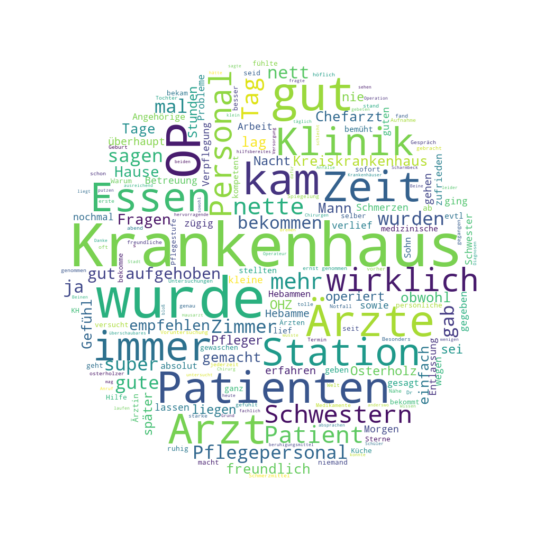

In [565]:
for p in range(len(df["Name der Klinik"].unique())):
    x, y = np.ogrid[:1000, :1000]
    mask = (x - 500) ** 2 + (y - 500) ** 2 > 400 ** 2
    mask = 255 * mask.astype(int)
    wordcloud = WordCloud(stopwords=german_stop_words,background_color="white",width=1920, height=1080, mask=mask).generate(str(reviewlist[p]))
    plt.imshow(wordcloud, extent=(8, 70, 8, 70), interpolation="bilinear")
    plt.axis("off")
    #plt.savefig('plot.png', dpi=300)
    #plt.savefig("drhoffmann.png", format="png")
    #plt.savefig("imgkreis/k_w_"+dfsentiment["Name der Klinik"][p]+".png", dpi=300)
    plt.savefig("wc_klinik1.1/k_w_"+listeneu[p]+".png", dpi=300)
    #plt.show()

### WordCloud GoogleMaps

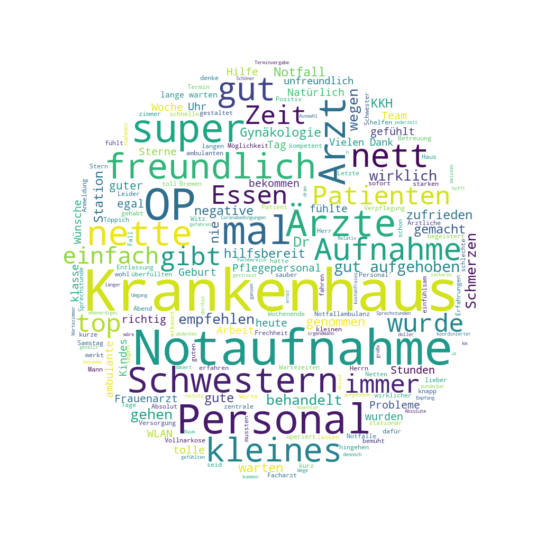

In [569]:
for p in range(len(df["Name der Klinik"].unique())):
    x, y = np.ogrid[:1000, :1000]
    mask = (x - 500) ** 2 + (y - 500) ** 2 > 400 ** 2
    mask = 255 * mask.astype(int)
    wordcloud = WordCloud(stopwords=german_stop_words,background_color="white",width=1920, height=1080, mask=mask).generate(str(reviewlistgoogle[p]))
    plt.imshow(wordcloud, extent=(8, 70, 8, 70), interpolation="bilinear")
    plt.axis("off")
    #plt.savefig('plot.png', dpi=300)
    #plt.savefig("drhoffmann.png", format="png")
    #plt.savefig("imgkreis/k_w_"+dfsentiment["Name der Klinik"][p]+".png", dpi=300)
    plt.savefig("imggoogle/k_w_"+listeneu[p]+".png", dpi=300)
    #plt.show()